In [161]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
from community import community_louvain
from matplotlib.cm import ScalarMappable
from sklearn.metrics import adjusted_rand_score
import random
import os
import json
from matplotlib.cm import ScalarMappable
from itertools import combinations, product
from sklearn.metrics import jaccard_score
import numpy as np


### Prepare the Network and Data

In [162]:
data_folder_path = '../data/'

all_data = {}

for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)

In [163]:
### Add sentiment score as a character attribute

characters_infobox = all_data['characters_infobox']
sentiment_scores_characters = all_data['sentiment_scores_charachters']

for character, info in characters_infobox.items():
    if character in sentiment_scores_characters:
        info['Sentiment Score'] = sentiment_scores_characters[character]


In [164]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    graph_dict = {}  # Initialize an empty dictionary to store graphs
    count = 1  # Initializing a count

    # Loop over every season
    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). Control statement for the first graph
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None:  # Control statement if the list of characters is empty/None type
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
                count += 1  # Updating the count

    else:
        # Initialize graph and graph dict to append the graphs
        season_data = data[season]  
        graph_dict = {}  # Initialize an empty dictionary to store graphs
        count = 1  # Initializing a count

        # Loop over every episode
        for i in range(len(season_data)):
            G = nx.Graph()  # Create a new directed graph for each episode
            characters = season_data[i]["Characters"]  # Characters from each episode as a list

            # Add nodes from the previous graph (if it exists). Control statement for the first graph
            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)
                
                # Add edges and update weights from the previous graph
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            # Add new characters as nodes
            if characters is not None:  # Control statement if the list of characters is empty/None type
                G.add_nodes_from(characters)  # Adding the characters

                # Add weighted edges for characters appearing in the same episode
                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
            count += 1  # Updating the count

    # Add node attributes to all graphs
    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

# Adding the note attributes from the characters' infobox.
def add_node_attributes(graph, attributes_dict):
    for node, attributes in attributes_dict.items():
        # Normalize the node name
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        # Check if the normalized node exists in the graph
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [240]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):
    # Create a copy of the cumulative graph to avoid modifying the original graph
    filtered_graph = cumulative_graph.copy()

    # Iterate through edges and remove those below the threshold in the final graph (G1013)
    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    # Identify isolated nodes and remove them
    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

In [165]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=characters_infobox)

### Graph Partitioning 

In [226]:
def compute_partition_and_modularity(graph, node_community_mapping=None):
    
    partition = community_louvain.best_partition(graph, partition=node_community_mapping)
    modularity = community_louvain.modularity(partition, graph)
    nx.set_node_attributes(graph, partition, 'community')

    return partition, modularity

def print_communities(partition):

    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = [node]
        else:
            communities[community].append(node)

    for community, nodes in sorted(communities.items()):
        print(f"Community {community}: {nodes}")

In [227]:
def visualize_network(graph, partition, layout='spring', title=''):
    
    if layout == 'spring':
       pos = nx.spring_layout(graph, seed=42) 
    elif layout == 'kamada-kawai':
        pos = nx.kamada_kawai_layout(graph)
    
    plt.figure(figsize=(12, 8))

    # Draw network nodes and edges
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
    edges = nx.draw_networkx_edges(graph, pos, alpha=0.5)

    # Add colorbar in a separate subplot
    cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
    sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
    sm.set_array([])

    # Set ticks for discrete values (assuming communities are integer values)
    ticks = sorted(set(partition.values()))
    plt.colorbar(sm, label='Community', cax=cax, ticks=ticks)

    plt.title(title)
    plt.show()

#### Partitioning Based On Villages

In [169]:
def assign_affiliation_labels(graph, target_villages):
    """
    Assigns community labels to nodes in a graph based on the 'Affiliation' attribute.

    Parameters:
    - graph: NetworkX graph
    - target_villages: List of target villages to check for in the 'Affiliation' attribute

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        affiliation_list = graph.nodes[node].get('Affiliation', [])

        matching_villages = [village for village in target_villages if village in affiliation_list]

        if matching_villages:
            community_label = matching_villages[0]
        elif affiliation_list:
            community_label = random.choice(affiliation_list)
        else:
            community_label = 'None'

        node_community_mapping[node] = community_label

    return node_community_mapping

#### Partitioning Based on Clans

In [52]:
def assign_clan_labels(graph):
    """
    Assigns community labels to nodes in a graph based on the 'Clan' attribute.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        clan_list = graph.nodes[node].get('Clan', [])
        community_label = random.choice(clan_list) if clan_list else 'None'
        node_community_mapping[node] = community_label

    return node_community_mapping


--------------------------------

## Community Developments Over Time

### Build the Networks for selected Episodes with min co-occurence constraint

In [241]:
episode_graphs_list = ['G20', 'G100', 'G220', 'G600', 'G720', 'G1013']
threshold = 100

filtered_graphs = {}
for episode in episode_graphs_list:
    filtered_graphs[episode] = filter_edges_below_threshold(graph_dict_all_seasons[episode], graph_dict_all_seasons['G1013'], threshold)

#### Up to Episode 20

Modularity: 0.12763456790123465
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka']
Community 2: ['Gaara', 'Temari', 'Kankurō']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


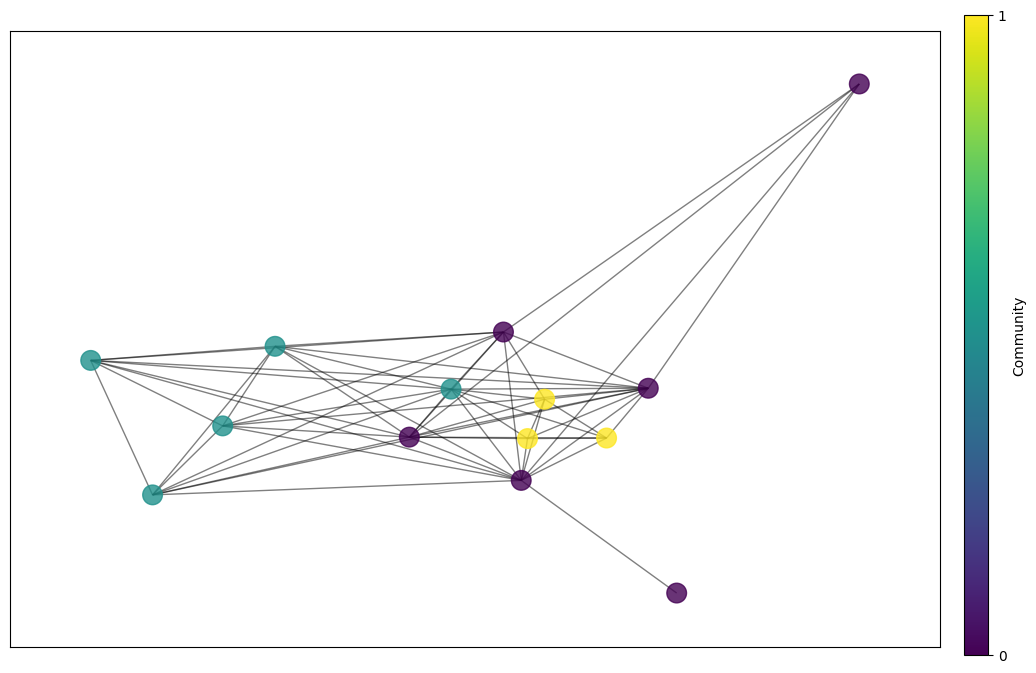

In [242]:
G20_filtered = filtered_graphs['G20']

partition, modularity = compute_partition_and_modularity(G20_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G20_filtered, partition, layout='kamada-kawai')

Modularity: 0.12257777777777783
Community 0: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Gaara', 'Temari', 'Kankurō']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


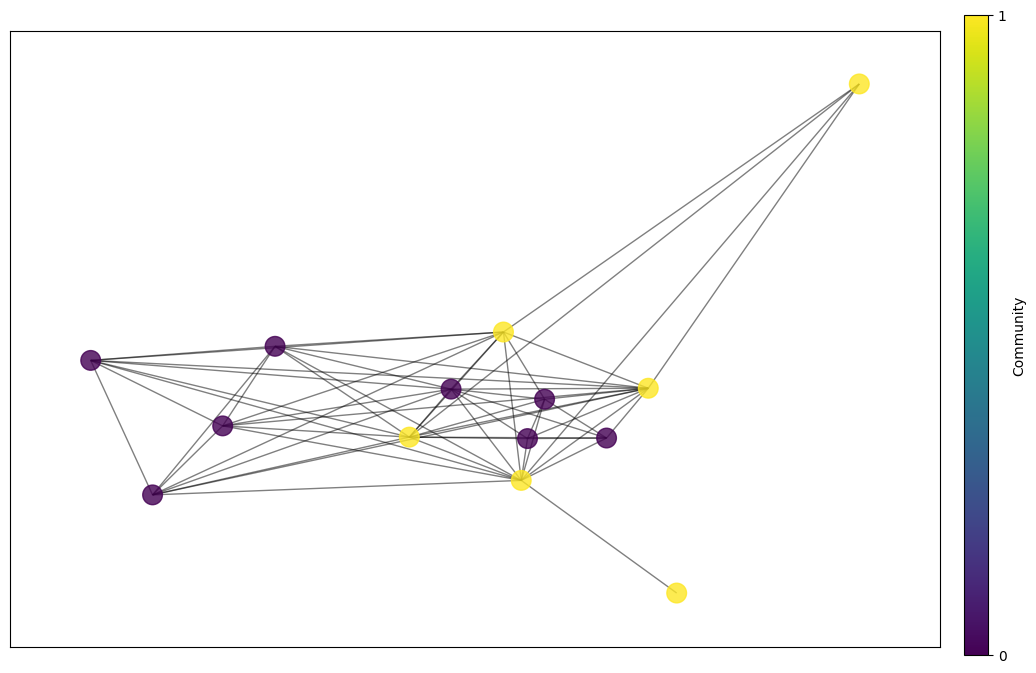

In [176]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G20_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G20_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G20_filtered, partition, layout='kamada-kawai')

Modularity: 0.14566880447895258
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame']
Community 2: ['Tsunade', 'Shizune']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


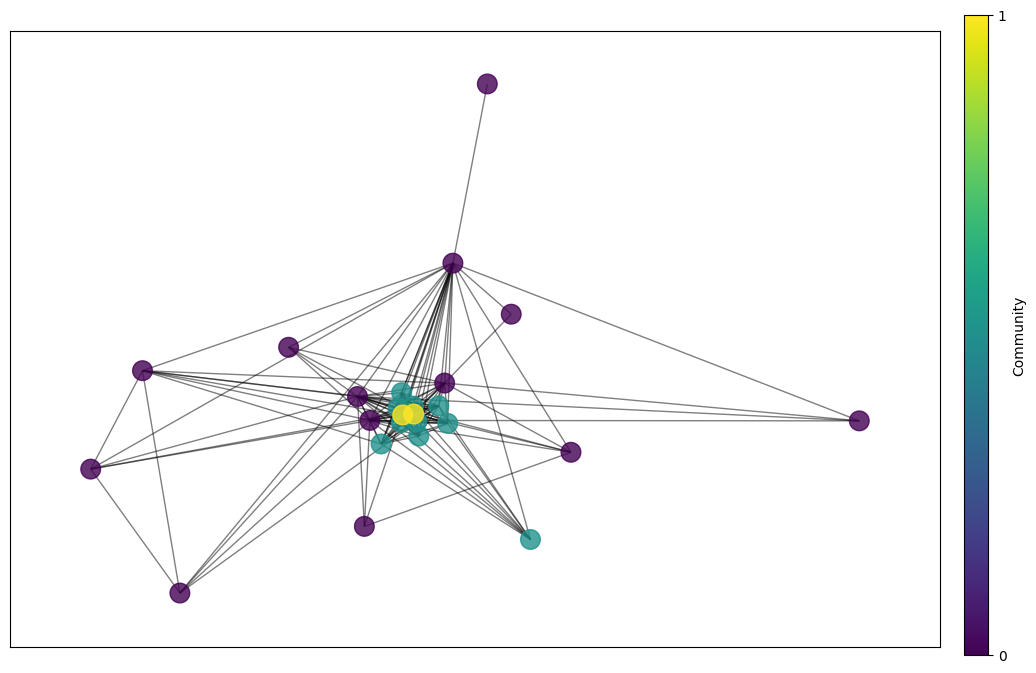

In [234]:
G100_filtered = filtered_graphs['G100']

partition, modularity = compute_partition_and_modularity(G100_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G100_filtered, partition, layout='kamada-kawai')

Modularity: 0.04515738753103432
Community 0: ['Shikamaru Nara', 'Gaara', 'Temari', 'Kankurō']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


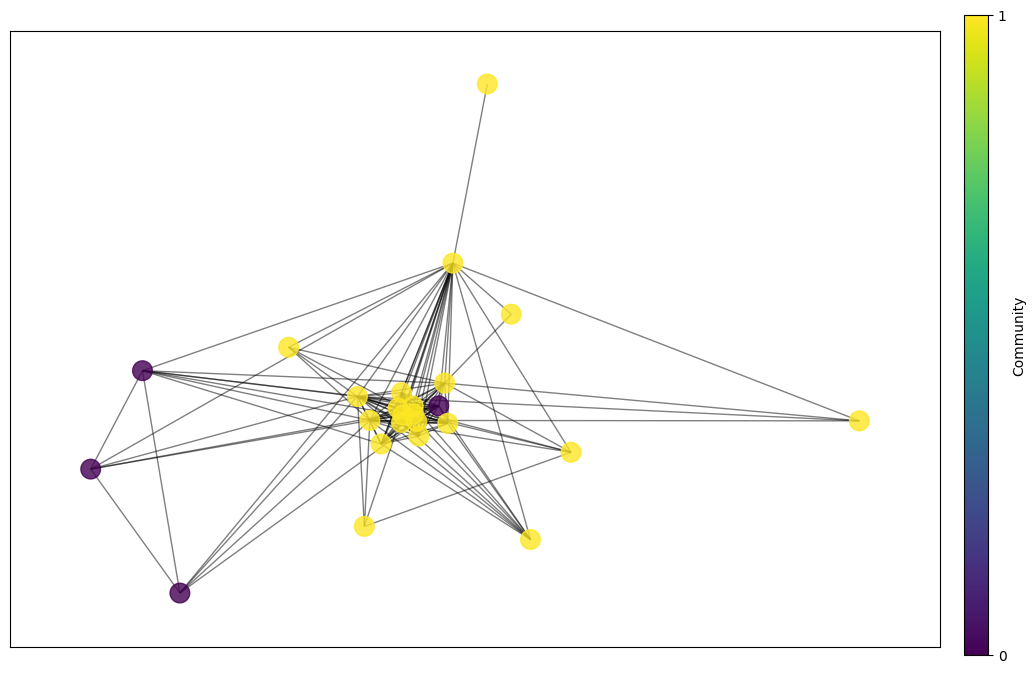

In [178]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G100_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G100_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G100_filtered, partition, layout='kamada-kawai')

#### Up to 600 Episodes

In [246]:
G600_filtered = filtered_graphs['G720']

Modularity: 0.13660162737295384
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame', 'Tsunade', 'Shizune']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


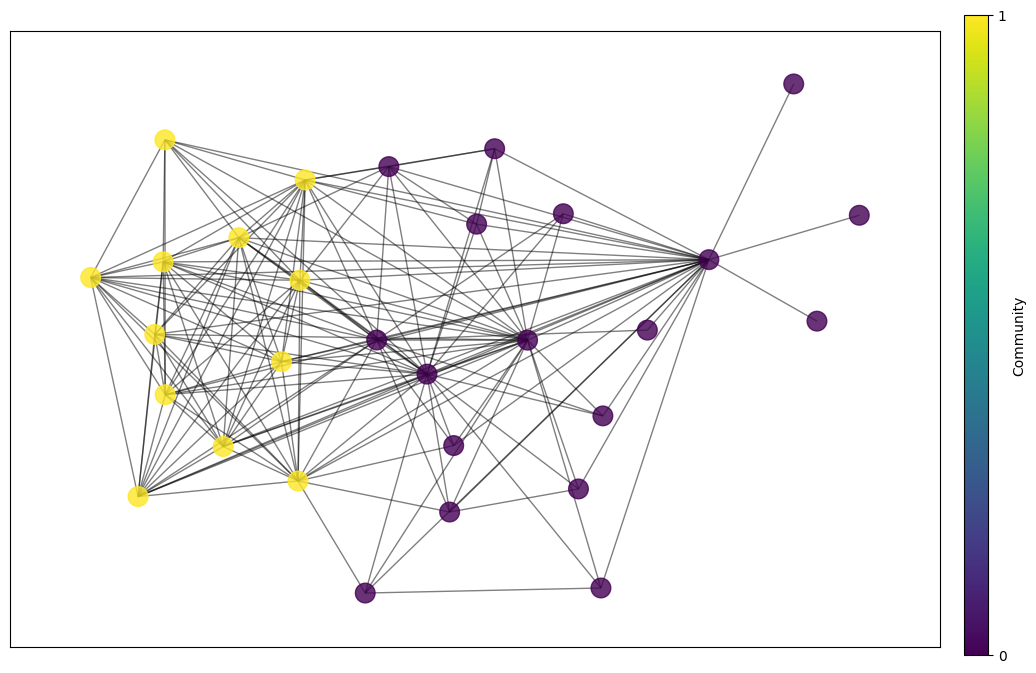

In [247]:
partition, modularity = compute_partition_and_modularity(G600_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G600_filtered, partition, layout='kamada-kawai')

Modularity: 0.02620625366910017
Community 0: ['Shikamaru Nara', 'Gaara', 'Temari', 'Kankurō']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


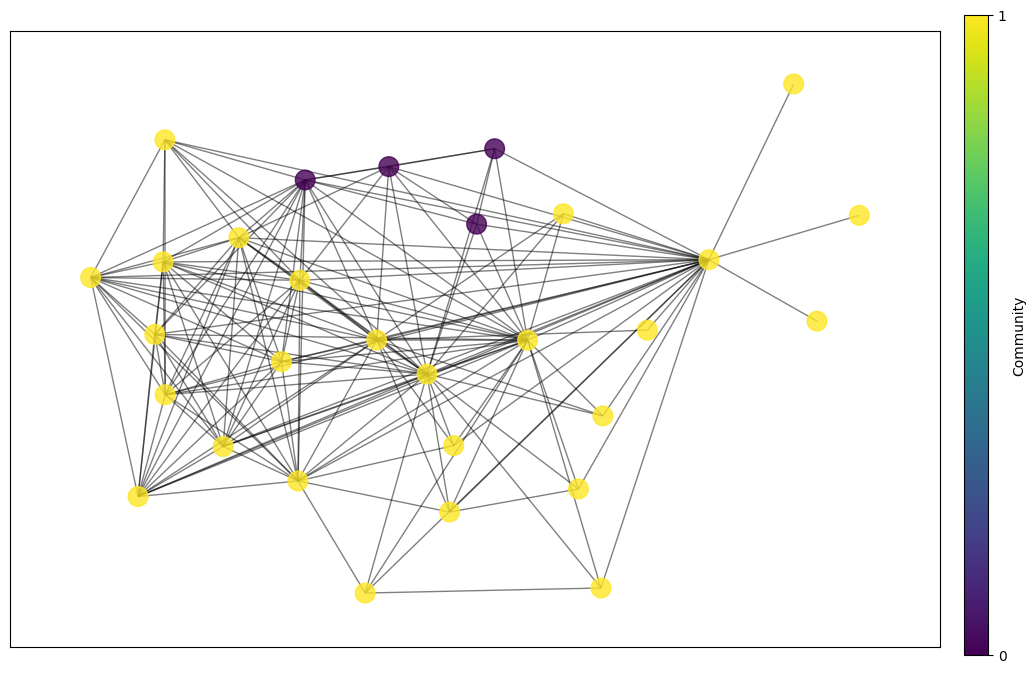

In [248]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G600_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G600_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G600_filtered, partition, layout='kamada-kawai')

#### Up to the final episode 

In [182]:
G1013_filtered = filtered_graphs['G1013']

Modularity: 0.271888735200004
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame']
Community 2: ['Konohamaru Sarutobi', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Inojin Yamanaka', 'Iwabee Yuino', 'Metal Lee', 'Mitsuki', 'Sai Yamanaka', 'Kawaki']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


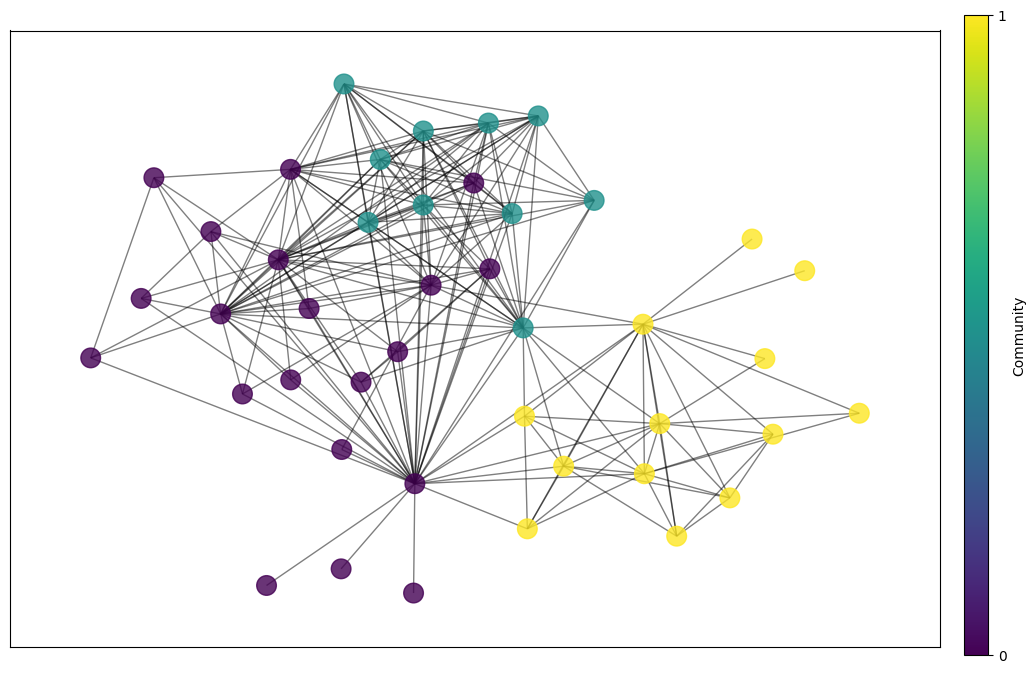

In [199]:
partition, modularity = compute_partition_and_modularity(G1013_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')

Modularity: 0.22927380212723883
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Sai', 'Yamato', 'Konohamaru Sarutobi', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Inojin Yamanaka', 'Iwabee Yuino', 'Metal Lee', 'Mitsuki', 'Sai Yamanaka', 'Kawaki']


C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


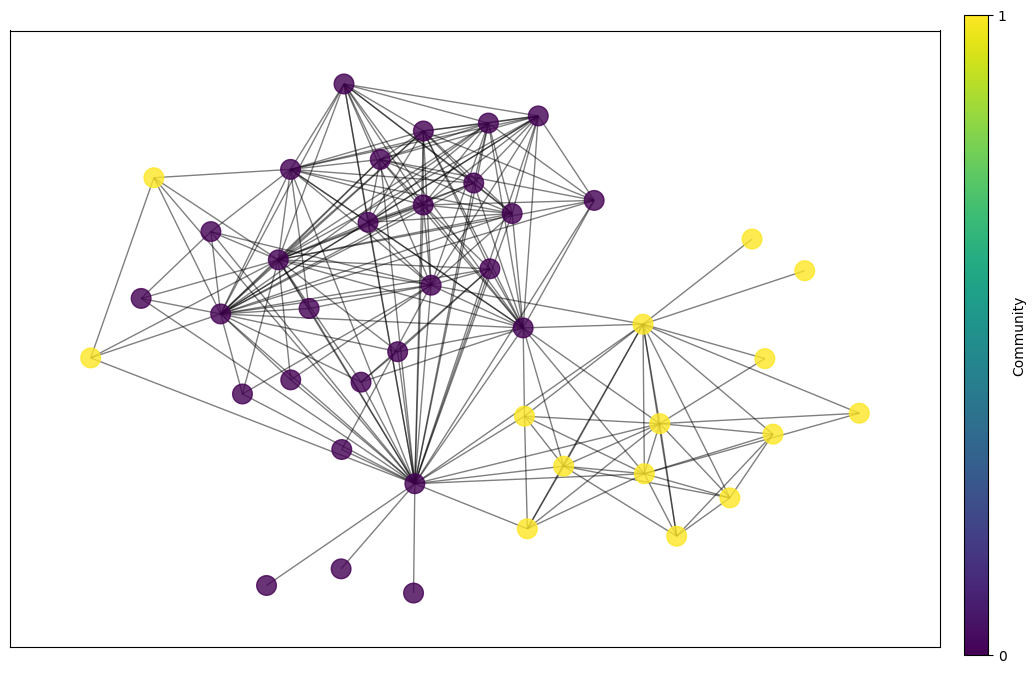

In [184]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G1013_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G1013_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')

#### Jaccard Similarity

In [231]:
def calculate_jaccard_similarity(graph1, graph2):
    # Extract communities for the two graphs
    communities_graph1 = nx.get_node_attributes(graph1, 'community')
    communities_graph2 = nx.get_node_attributes(graph2, 'community')

    # Calculate Jaccard similarity for all pairs of communities
    jaccard_similarities = []
    for community1, community2 in product(set(communities_graph1.values()), set(communities_graph2.values())):
        members1 = get_community_members(graph1, community1)
        members2 = get_community_members(graph2, community2)

        # Create binary vectors indicating membership for all nodes in the union of both communities
        all_nodes = set(members1 + members2)
        binary_vector1 = np.array([node in members1 for node in all_nodes], dtype=int)
        binary_vector2 = np.array([node in members2 for node in all_nodes], dtype=int)

        # Calculate Jaccard similarity between two communities
        jaccard_similarity = jaccard_score(binary_vector1, binary_vector2)

        jaccard_similarities.append({
            'Community1': community1,
            'Community2': community2,
            'Jaccard Similarity': jaccard_similarity
        })

    return jaccard_similarities


def get_community_members(graph, community):
    return [node for node, data in graph.nodes(data=True) if data['community'] == community]

In [237]:
jaccard_similarities = calculate_jaccard_similarity(G20_filtered, G100_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.23076923076923078}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 0, 'Community2': 2, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 0.5}
{'Community1': 1, 'Community2': 2, 'Jaccard Similarity': 0.0}
{'Community1': 2, 'Community2': 0, 'Jaccard Similarity': 0.46153846153846156}
{'Community1': 2, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 2, 'Community2': 2, 'Jaccard Similarity': 0.0}


In [238]:
jaccard_similarities = calculate_jaccard_similarity(G100_filtered, G600_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.7222222222222222}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 0.8333333333333334}
{'Community1': 2, 'Community2': 0, 'Jaccard Similarity': 0.0}
{'Community1': 2, 'Community2': 1, 'Jaccard Similarity': 0.16666666666666666}


In [239]:
jaccard_similarities = calculate_jaccard_similarity(G600_filtered, G1013_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.7777777777777778}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.13333333333333333}
{'Community1': 0, 'Community2': 3, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 0.75}
{'Community1': 1, 'Community2': 3, 'Jaccard Similarity': 0.0}
